# Introduction to Quantum Computing (Lab 5 — Quantum Tic-Tac-Toe)
In this lab you will an actual quantum game! Have fun 😀


In this lab you will an actual quantum game! Have fun 😀

In [ ]:
# Install required packages (only needed in Colab)
!pip install qiskit --quiet
!pip install qiskit-aer --quiet
!pip install pylatexenc --quiet


In [ ]:
# Install required modules (only needed in Colab, not in VS Code/Jupyter)
# !pip install qiskit --quiet
# !pip install qiskit-aer --quiet
# !pip install pylatexenc --quiet

# Core Qiskit imports
from qiskit import QuantumCircuit, execute
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector
from qiskit.quantum_info import Statevector

# Widgets (only if running in Colab, else comment out)
# from google.colab import widgets

# ipywidgets (works in Jupyter/VS Code)
from ipywidgets import interact, interactive, fixed, interact_manual, Button, Layout
import ipywidgets

# General Python utilities
import pandas as pd
import math
import numpy as np
import random

# Display helpers
from IPython.display import clear_output, display
# Core Qiskit imports
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector
from qiskit.quantum_info import Statevector



ImportError: cannot import name 'execute' from 'qiskit' (c:\Users\DHEERAJ KUMAR\.conda\envs\MSE800DHEERAJ\Lib\site-packages\qiskit\__init__.py)

The code for the game comprises the two classes below. Edit at your peril. But, also, edit if you want to change the rules of the game!

In [7]:
class Board:
    def __init__(self):
        # Quantum circuit with 9 qubits (cells) and 9 classical bits (measurements)
        self.qc = QuantumCircuit(9, 9)
        self.function = ''
        self.target = -1
        self.tab = []
        self.winsX = 0
        self.winsO = 0

        # Initialize each cell in superposition
        for idx in range(0, 9):
            self.tab.append({'default': str(idx), 'player': ' '})
            self.qc.reset(idx)   # reset to |0>
            self.qc.h(idx)       # Hadamard: put into superposition
        self.qc.barrier()

    def make_move(self, cell):
        if self.function == 'Not':
            # add an X gate (Pauli-X flip)
            self.qc.x(int(cell))
            self.tab[int(cell)]['player'] += 'N - '

        elif self.function == 'O':
            # add a rotation toward |0> (RY(-π/4))
            self.qc.ry(-0.785398163, int(cell))
            self.tab[int(cell)]['player'] += "O - "

        elif self.function == 'X':
            # add a rotation toward |1> (RY(+π/4))
            self.qc.ry(0.785398163, int(cell))
            self.tab[int(cell)]['player'] += "X - "

        elif self.function == 'SWAP' and self.target != cell:
            if self.target == cell:
                self.target = -1
            else:
                # add a swap gate
                self.qc.swap(self.target, int(cell))
                self.tab[int(cell)]['player'] += "S - "
                self.tab[int(self.target)]['player'] += "S - "
                self.target = -1

    def results(self):
        # Display circuit diagram
        display(self.qc.draw('mpl'))
        # Reset circuit for new game
        self.qc = QuantumCircuit(9, 9)

    def display(self):
        display(self.qc.draw('mpl'))

    def measure(self):
        # Finalize circuit and measure all qubits
        self.qc.barrier()
        for i in range(0, 9):
            self.qc.measure(i, i)

        simulator = AerSimulator()
        job = simulator.run(self.qc, shots=1)
        counts = job.result().get_counts()
        output = list(counts.keys())[0]

        # Map measurement results to players
        for i in range(0, 9):
            if output[9 - 1 - i] == '0':
                self.tab[i]['player'] = 'X'
            else:
                self.tab[i]['player'] = 'O'

        # Count wins
        self.winsX = self.countWinners('X')
        self.winsO = self.countWinners('O')

    def countWinners(self, player):
        # 8 winning conditions (rows, columns, diagonals)
        winners = (
            (0, 1, 2),
            (3, 4, 5),
            (6, 7, 8),
            (0, 3, 6),
            (1, 4, 7),
            (2, 5, 8),
            (0, 4, 8),
            (2, 4, 6),
        )
        wins = 0
        for line in winners:
            if all(self.tab[idx]['player'] == player for idx in line):
                wins += 1
        return wins

    def new(self):
        # Reset board and circuit
        self.tab.clear()
        for idx in range(0, 9):
            self.tab.append({'default': str(idx), 'player': ''})
            self.qc.reset(idx)
            self.qc.h(idx)
        self.qc.barrier()


In [8]:
class Game:
    def __init__(self):
        # Flag for SWAP target selection
        self.selecting = False
        # Create a Board object
        self.board = Board()
        # Buttons for each cell (0–8)
        self.boardbutton_list = []
        for i in range(0, 9):
            button = Button(description=str(i))
            button.on_click(self.handle_game)
            self.boardbutton_list.append(button)

        # Function buttons (Measure, Not, O, X, SWAP)
        self.funcbutton_list = []
        self.newButton('Measure')
        self.newButton('Not')
        self.newButton('O')
        self.newButton('X')
        self.newButton('SWAP')

        # Initial UI
        self.printmenu()
        self.printBoard()

    def newButton(self, name):
        """Create a function button and attach handler."""
        function = Button(description=name, layout=Layout(width='86px', height='30px'))
        function.on_click(self.handle_game)
        self.funcbutton_list.append(function)

    def handle_game(self, b):
        """Handle button clicks for moves and functions."""
        try:
            if b.description == 'Measure':
                clear_output()
                self.replay()
                self.board.measure()
                self.scoreboard()
                self.printBoard()
                self.board.results()

            if b.description == 'Replay':
                clear_output()
                self.board.new()
                self.printmenu()
                self.printBoard()

            # If a cell button (0–8) is clicked
            if int(b.description) >= 0:
                if self.selecting:
                    # Second click for SWAP target
                    self.board.target = int(b.description)
                else:
                    clear_output()
                    self.printmenu()
                    self.board.make_move(int(b.description))
                    self.printBoard()
                    self.board.display()
            self.selecting = False

        except ValueError:
            # If a function button is clicked (Not, O, X, SWAP)
            self.board.function = b.description
            self.selecting = False
            if self.board.function == 'SWAP':
                # Next click will select target cell
                self.selecting = True

    def printmenu(self):
        """Display function buttons in a grid."""
        grid = widgets.Grid(1, 5)
        for (row, col) in grid:
            display(self.funcbutton_list[col])

    def scoreboard(self):
        """Print current score (wins for X and O)."""
        print("X wins: " + str(self.board.winsX) + "    O wins: " + str(self.board.winsO))

    def replay(self):
        """Add a Replay button to restart the game."""
        rep = Button(description="Replay")
        rep.on_click(self.handle_game)
        display(rep)

    def printBoard(self):
        """Display the board grid with cell buttons and current marks."""
        grid = widgets.Grid(1, int(np.sqrt(9)), header_row=True, header_column=True)
        for row in range(int(np.sqrt(9))):
            for (useless, col) in grid:
                print("\n" + self.board.tab[col + row * int(np.sqrt(9))]['player'] + "\n")
                display(self.boardbutton_list[col + row * int(np.sqrt(9))])


In this iteration, we'll play the game on the qiskit simulator.

## The game!
To make a move, click one of the 5 options above the board and then click the location where you want to make that move. To play "SWAP," you need to click two board locations.

Each move adds a gate to the game circuit. They do the following:

* **Measure** ends the round and execute the game circuit on the quantum device. The win conditions will be counted and displayed.
* **Not** flips an "owned" tile to the other player. If the tile is not currently owned, this does nothing.
* **O** turns the intial tile toward a tile owned by "O."
* **X** turns the intial tile toward a tile owned by "X."
* **SWAP** swaps the location of two tiles.

As you play, you will see the game circuit and the board. The board shows the sequence of moves, but is not 100% accurate. The game circuit is true state of the game.

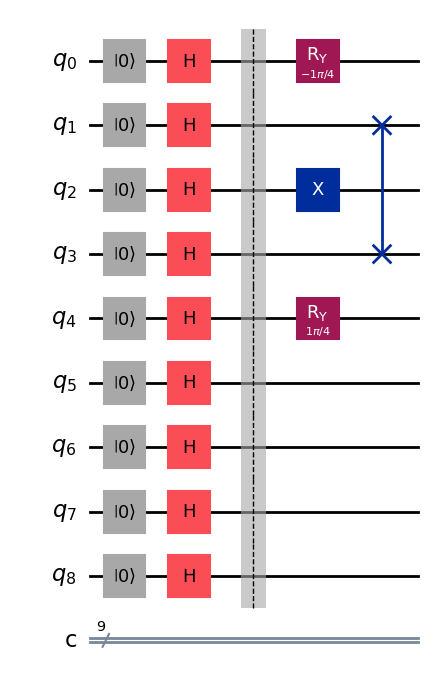

TypeError: Board.measure() got an unexpected keyword argument 'shots'

In [ ]:
board = Board()

board.function = 'X'
board.make_move(4)   # Center

board.function = 'O'
board.make_move(0)   # Top-left

board.function = 'Not'
board.make_move(2)   # Top-right

board.function = 'SWAP'
board.target = 1
board.make_move(3)   # Swap with left-middle

board.display()

counts, top_state = board.measure(shots=1024)
print("Top state:", top_state)
print("Board:", [cell['player'] for cell in board.tab])
print("WinsX:", board.winsX, "WinsO:", board.winsO)


In [ ]:
pip show pylatexenc


Name: pylatexenc
Version: 2.10
Summary: Simple LaTeX parser providing latex-to-unicode and unicode-to-latex conversion
Home-page: https://github.com/phfaist/pylatexenc
Author: Philippe Faist
Author-email: philippe.faist@bluewin.ch
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 
